<a href="https://colab.research.google.com/github/rakeshsurampalli/smart_investment/blob/master/simpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



#3. Read file as panda dataframe


In [0]:

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1uXnme3jK0iwMN6tBujDWVU1Td2fj2k3T'}) # replace the id with id of file you want to access
downloaded.GetContentFile('RELIANCE20.csv')  

In [0]:
import pandas as pd
sales = pd.read_csv('RELIANCE20.csv') 

In [5]:
sales.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,16.009800,16.095699,15.904300,16.0683,2.412877,47600787.0
1,1996-01-02,16.029301,16.107401,15.826200,15.9434,2.394122,77143764.0
2,1996-01-03,16.205000,16.943001,16.029301,16.0644,2.412292,95695836.0
3,1996-01-04,15.912100,15.962900,15.701300,15.9160,2.390007,99159504.0
4,1996-01-05,15.853600,15.853600,15.670000,15.8067,2.373594,76213503.0


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
import pandas as pd
import numpy as np
from google.colab import files
from pandas import datetime
import matplotlib.pyplot as plt


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

MessageError: ignored

In [96]:
import io
def parser(x):
  return datetime.strptime(x,'%d/%m/%y')

sales = pd.read_csv(io.StringIO(uploaded['reliance1.csv'].decode('utf-8')),index_col=0,parse_dates=[0],date_parser=parser)

NameError: ignored

In [10]:
sales.head()
print("checking if any null values are present\n", sales.isna().sum())

checking if any null values are present
 Date           0
Open         126
High         126
Low          126
Close        126
Adj Close    126
Volume       126
dtype: int64


In [11]:
sales = sales.dropna()
print("checking if any null values are present\n", sales.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ValueError: ignored

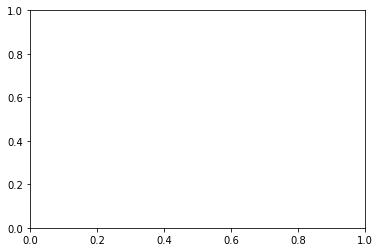

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales)

In [0]:
sales_diff = sales.Close.diff(periods=1)

In [13]:
sales = sales_diff[1:]
sales.head()

1   -0.1249
2    0.1210
3   -0.1484
4   -0.1093
5   -0.6326
Name: Close, dtype: float64

In [14]:
X = sales
time = np.arange(6026)

print(X)
X.size
split_time = 6000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = X[0:split_time]
x_test = X[split_time:]


1       -0.124900
2        0.121000
3       -0.148400
4       -0.109300
5       -0.632600
          ...    
6148    -9.699951
6149    -7.500000
6150    21.500000
6151    26.699951
6152    -7.849976
Name: Close, Length: 6026, dtype: float64


In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train,window_size,batch_size = 128,shuffle_buffer = shuffle_buffer_size)

In [0]:
model = keras.models.Sequential([
                      keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1)),
                      keras.layers.SimpleRNN(20, return_sequences = True,
                                               input_shape = [None,1]),
                      keras.layers.SimpleRNN(20),
                      keras.layers.Dense(1),
                      keras.layers.Lambda(lambda x: x*100.0)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

In [0]:
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

In [21]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

47/47 [==============================] - 1s 15ms/step - loss: 49.7659 - mae: 50.2643 - lr: 1.0000e-08
Epoch 2/100
47/47 [==============================] - 1s 15ms/step - loss: 49.6483 - mae: 50.1469 - lr: 1.1220e-08
Epoch 3/100
47/47 [==============================] - 1s 14ms/step - loss: 49.5141 - mae: 50.0127 - lr: 1.2589e-08
Epoch 4/100
47/47 [==============================] - 1s 15ms/step - loss: 49.3636 - mae: 49.8622 - lr: 1.4125e-08
Epoch 5/100
47/47 [==============================] -

[-4.4083123   6.7708864  -4.402801    6.7739153   6.7708397  -4.204411
  0.8320054  -4.416849    6.771126   -4.4168773  -0.614437    6.770841
 -4.076473    6.790949   -4.415309   -4.415009    6.6890225   6.7750573
  6.7260394  -2.510657    6.770841    5.266554    6.7807546   6.387354
  0.23112865  0.47065383]


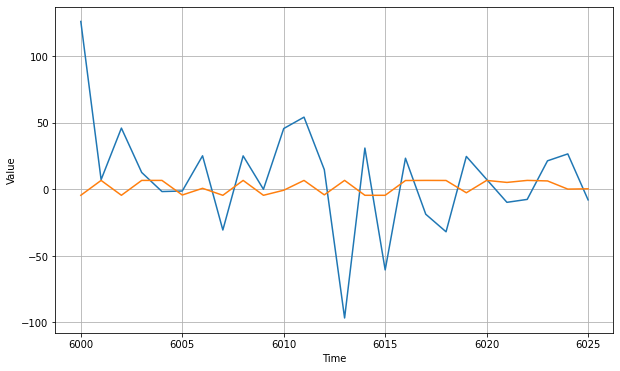

In [22]:
predictions = []
for time in range(len(X) - window_size):
  predictions.append(model.predict(X[time:time + window_size,np.newaxis]))

predictions = predictions[split_time-window_size:]
results = np.array(predictions)[:, 0, 0]
print(results)

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_test)
plot_series(time_valid, results)
